In [ ]:
import scanpy as sc
import scipy
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import re
import psutil
from typing import Optional, Tuple, Dict, Any
import logging

# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [2]:
# load male and female adata and aggregate
adata_corrected_female = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_female_2025.h5ad')
adata_corrected_male = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_male_2025.h5ad')

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata_corrected_male

AnnData object with n_obs × n_vars = 40949 × 32285
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [4]:
adata_corrected_female

AnnData object with n_obs × n_vars = 38749 × 32285
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [5]:
same_set = set(adata_corrected_female.var_names) == set(adata_corrected_male.var_names)
print("Same gene set?", same_set)
print("A genes:", adata_corrected_female.n_vars, "B genes:", adata_corrected_male.n_vars)

Same gene set? True
A genes: 32285 B genes: 32285


#### Concat the two pools and name their batches

In [6]:
for adx in (adata_corrected_female, adata_corrected_male):
    adx.var_names = adx.var_names.astype(str)
    adx.var_names_make_unique()

In [8]:
adata_cellbender_combined = ad.concat(
    {"male": adata_corrected_male, "female": adata_corrected_female},
    axis=0,
    join="inner",         # use "outer" if you want union of genes (missing filled with 0)
    label="batch",
    index_unique=None     # keep original cell barcodes (ensure they won't collide)
)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [32]:
adata_cellbender_combined

AnnData object with n_obs × n_vars = 79698 × 32285
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
    obsm: 'gene_expression_encoding'

In [33]:
adata_cellbender_combined.obs['batch'].value_counts()

batch
male      40949
female    38749
Name: count, dtype: int64

In [29]:
def remove_duplicates(adata, axis='obs', strategy='first'):
    """
    Remove barcode duplicates with different strategies
    
    Parameters:
    - axis: 'obs' for cells, 'var' for genes
    - strategy: 'first', 'last', 'highest_counts' (for obs only)
    """
    if axis == 'obs':
        index = adata.obs.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        elif strategy == 'highest_counts':
            # Keep the cell with highest UMI counts among duplicates
            keep_indices = []
            for name in index.unique():
                name_mask = index == name
                if name_mask.sum() > 1:  # If duplicated
                    if 'nCount_RNA' in adata.obs.columns:
                        best_idx = adata.obs.loc[name_mask, 'nCount_RNA'].idxmax()
                        keep_indices.extend([i for i, idx in enumerate(adata.obs.index) if idx == best_idx])
                    else:
                        # Fall back to first if no count info
                        keep_indices.append(np.where(name_mask)[0][0])
                else:
                    keep_indices.extend(np.where(name_mask)[0])
            keep_mask = np.zeros(adata.n_obs, dtype=bool)
            keep_mask[keep_indices] = True
        
        return adata[keep_mask].copy()
    
    else:  # axis == 'var'
        index = adata.var.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        else:
            keep_mask = ~index.duplicated(keep='first')  # Default to first
        
        return adata[:, keep_mask].copy()

In [35]:
print("\n=== Removing Duplicates ===")
original_shape = adata_cellbender_combined.shape
# Remove cell duplicates (keeping first occurrence)
adata_subset = remove_duplicates(adata_cellbender_combined, axis='obs', strategy='first')


=== Removing Duplicates ===


In [36]:
dup_mask = adata_subset.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_subset.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_subset.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

Number of duplicated barcodes in corrected data: 0
Series([], Name: count, dtype: int64)
Unique genes in corrected data: 32285


In [37]:
adata_subset

AnnData object with n_obs × n_vars = 79240 × 32285
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
    obsm: 'gene_expression_encoding'

In [38]:
# save the combined adata
adata_subset.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')

## Combine the two adatas

In [23]:
# load datasets
adata_corrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')
adata_uncorrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/ERCC1_KO_mice_aggr_updated.h5ad')

In [24]:
adata_uncorrected.obs

,sample_id,condition,sex,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,...,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,n_genes,doublet_score,predicted_doublet
AAACCCGCAATCGTGG-1,F785_KO,KO,F,426,6.056784,727.0,6.590301,38.514443,29.0,3.401197,...,0.0,0.0,0.0,0.0,0.0,False,False,426,0.053115,False
AAACCCGCAATTAGGC-1,F785_KO,KO,F,627,6.442540,1156.0,7.053586,36.591696,30.0,3.433987,...,0.0,0.0,0.0,0.0,0.0,False,False,627,0.059406,False
AAACCCGCACTAGGCA-1,F785_KO,KO,F,1756,7.471363,4238.0,8.352082,25.696083,106.0,4.672829,...,0.0,0.0,0.0,0.0,0.0,False,False,1756,0.082290,False
AAACCCGCAGCCATCT-1,F785_KO,KO,F,1408,7.250636,3132.0,8.049747,28.895275,45.0,3.828641,...,0.0,0.0,0.0,0.0,0.0,False,False,1408,0.109375,False
AAACGGACAAATCGTA-1,F785_KO,KO,F,1607,7.382746,3542.0,8.172729,23.969509,69.0,4.248495,...,0.0,0.0,0.0,0.0,0.0,False,False,1607,0.136364,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGCCCTCCACCTGC-8,M6_WT,WT,M,908,6.812345,1834.0,7.514800,30.370774,61.0,4.127134,...,0.0,0.0,0.0,0.0,0.0,False,False,907,0.075823,False
TGTGCCCTCCTCTCTC-8,M6_WT,WT,M,877,6.777647,1527.0,7.331715,24.557957,38.0,3.663562,...,0.0,0.0,0.0,0.0,0.0,False,False,875,0.159948,False
TGTGCCCTCGTCTCGC-8,M6_WT,WT,M,902,6.805723,1744.0,7.464510,30.217890,20.0,3.044523,...,0.0,0.0,0.0,0.0,0.0,False,False,901,0.048017,False
TGTGCCCTCTAACCTC-8,M6_WT,WT,M,372,5.921578,623.0,6.436151,38.202247,7.0,2.079442,...,0.0,0.0,0.0,0.0,0.0,False,False,372,0.032958,False


In [ ]:
# Use regex to replace any suffix _2 through _8 with _1
adata_uncorrected.obs.index = adata_uncorrected.obs.index.str.replace(r'-[2-8]$', '-1', regex=True)

In [30]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

Number of duplicated barcodes in corrected data: 290
TGTGCATGTAATGAAC-1    2
AACCACGCATAGGGCC-1    2
TATGTCAGTTGCGGTC-1    2
TAGGTAGGTTCCATCC-1    2
TACCATAGTTGCTCAG-1    2
                     ..
ACGGTTGCACTTCAGC-1    2
ACCTGGACAACTGTGG-1    2
ACCGCAACATTAGATG-1    2
ACCACCTCATTCGTGC-1    2
ACCAAGTCAATACCGG-1    2
Name: count, Length: 290, dtype: int64
Unique genes in corrected data: 32285


In [31]:
print("\n=== Removing Duplicates ===")
original_shape = adata_uncorrected.shape
# Remove cell duplicates (keeping first occurrence)
adata_uncorrected = remove_duplicates(adata_uncorrected, axis='obs', strategy='first')


=== Removing Duplicates ===


In [32]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

Number of duplicated barcodes in corrected data: 0
Series([], Name: count, dtype: int64)
Unique genes in corrected data: 32285


In [33]:
# find overlapping cells
common_cells = adata_uncorrected.obs.index.intersection(adata_corrected.obs.index)
common_genes = adata_uncorrected.var.index.intersection(adata_corrected.var.index)
print(f"Found {len(common_cells)} common cells")
print(f"Found {len(common_genes)} common genes")

Found 61705 common cells
Found 32285 common genes


In [34]:
adata_orig_subset = adata_uncorrected[common_cells, common_genes].copy()
adata_corrected_subset = adata_corrected[common_cells, common_genes].copy()

In [35]:
# copy over all processed data
adata_combined = adata_orig_subset.copy()

In [36]:
# add cellbender counts as layer
adata_combined.layers['cellbender'] = adata_corrected_subset.X.copy()

In [37]:
print("Transferring cell metadata (obs)...")
for col in adata_corrected_subset.obs.columns:
    if col not in adata_combined.obs.columns:
        # Initialize new column with appropriate dtype
        if adata_corrected_subset.obs[col].dtype == 'object':
            adata_combined.obs[col] = pd.NA
        else:
            adata_combined.obs[col] = np.nan
    
    # Update values for common cells
    adata_combined.obs[col] = adata_corrected_subset.obs[col]

Transferring cell metadata (obs)...


In [38]:
adata_combined.obs

,sample_id,condition,sex,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,...,outlier,mt_outlier,n_genes,doublet_score,predicted_doublet,background_fraction,cell_probability,cell_size,droplet_efficiency,batch
AAACCCGCAATCGTGG-1,F785_KO,KO,F,426,6.056784,727.0,6.590301,38.514443,29.0,3.401197,...,False,False,426,0.053115,False,0.697943,0.996568,2372.278076,0.582428,female
AAACCCGCAATTAGGC-1,F785_KO,KO,F,627,6.442540,1156.0,7.053586,36.591696,30.0,3.433987,...,False,False,627,0.059406,False,0.590243,0.995604,2727.047852,0.727489,female
AAACCCGCACTAGGCA-1,F785_KO,KO,F,1756,7.471363,4238.0,8.352082,25.696083,106.0,4.672829,...,False,False,1756,0.082290,False,0.059798,0.999955,4281.843262,1.375871,female
AAACCCGCAGCCATCT-1,F785_KO,KO,F,1408,7.250636,3132.0,8.049747,28.895275,45.0,3.828641,...,False,False,1408,0.109375,False,0.095512,0.999531,3813.677979,1.187584,female
AAACGGACAAATCGTA-1,F785_KO,KO,F,1607,7.382746,3542.0,8.172729,23.969509,69.0,4.248495,...,False,False,1607,0.136364,False,0.066273,0.999813,4334.787109,1.128114,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGCCCTCCACCTGC-1,M6_WT,WT,M,908,6.812345,1834.0,7.514800,30.370774,61.0,4.127134,...,False,False,907,0.075823,False,0.228600,0.999950,2426.421387,1.073309,male
TGTGCCCTCCTCTCTC-1,M6_WT,WT,M,877,6.777647,1527.0,7.331715,24.557957,38.0,3.663562,...,False,False,875,0.159948,False,0.148233,0.999252,2246.069580,1.030120,male
TGTGCCCTCGTCTCGC-1,M6_WT,WT,M,902,6.805723,1744.0,7.464510,30.217890,20.0,3.044523,...,False,False,901,0.048017,False,0.108752,0.999906,2318.659424,1.087894,male
TGTGCCCTCTAACCTC-1,M6_WT,WT,M,372,5.921578,623.0,6.436151,38.202247,7.0,2.079442,...,False,False,372,0.032958,False,0.554765,0.996725,1639.745850,0.641182,male


In [39]:
# Transfer obsm with logging
print(f"Transferring {len(adata_corrected_subset.obsm.keys())} obsm entries:")
for key in adata_corrected_subset.obsm.keys():
    print(f"  - {key}: {adata_corrected_subset.obsm[key].shape}")
    adata_combined.obsm[key] = adata_corrected_subset.obsm[key].copy()

# Transfer varm with logging
print(f"Transferring {len(adata_corrected_subset.varm.keys())} varm entries:")
for key in adata_corrected_subset.varm.keys():
    print(f"  - {key}: {adata_corrected_subset.varm[key].shape}")
    adata_combined.varm[key] = adata_corrected_subset.varm[key].copy()

# Transfer uns with logging
print(f"Transferring {len(adata_corrected_subset.uns.keys())} uns entries:")
for key in adata_corrected_subset.uns.keys():
    print(f"  - {key}")
    adata_combined.uns[key] = adata_corrected_subset.uns[key]

Transferring 1 obsm entries:
  - gene_expression_encoding: (61705, 64)
Transferring 0 varm entries:
Transferring 0 uns entries:


In [40]:
adata_combined

AnnData object with n_obs × n_vars = 61705 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'sample_id_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'counts', 'cellbender'

# Analyze the combined data

In [25]:
infile = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_combined.h5ad'

In [ ]:
adata_combined = sc.read_h5ad(infile)

In [13]:
adata_combined

AnnData object with n_obs × n_vars = 61705 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'sample_id_colors', 'scrublet'
    obsm: 'gene_expression_encoding'
    layers: 'cellbender', 'counts'

### Compare performance of correcting counts matrix

In [19]:
adata_combined.X = adata_combined.layers['cellbender']

In [ ]:
# add the vars you need to get per-gene metrics on (for corrected counts add new var columns)
adata_combined.var['mt_cb'] = adata_combined.var_names.str.startswith('mt-')
adata_combined.var['ribo_cb'] = adata_combined.var_names.str.startswith(('rps', 'rpl'))
adata_combined.var["hb_cb"] = adata_combined.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata_combined, qc_vars=["mt_cb", "ribo_cb", "hb_cb"], inplace=True, percent_top=[20], log1p=True
)
adata_combined

AnnData object with n_obs × n_vars = 61705 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    uns: 'log1p', 's

In [26]:
# cut of cells to compare cellbender vs uncorrected counts on the same scale
adata_combined = adata_combined[adata_combined.obs['total_counts_mt_cb'] < 300]
adata_combined = adata_combined[adata_combined.obs['total_counts_mt'] < 300]

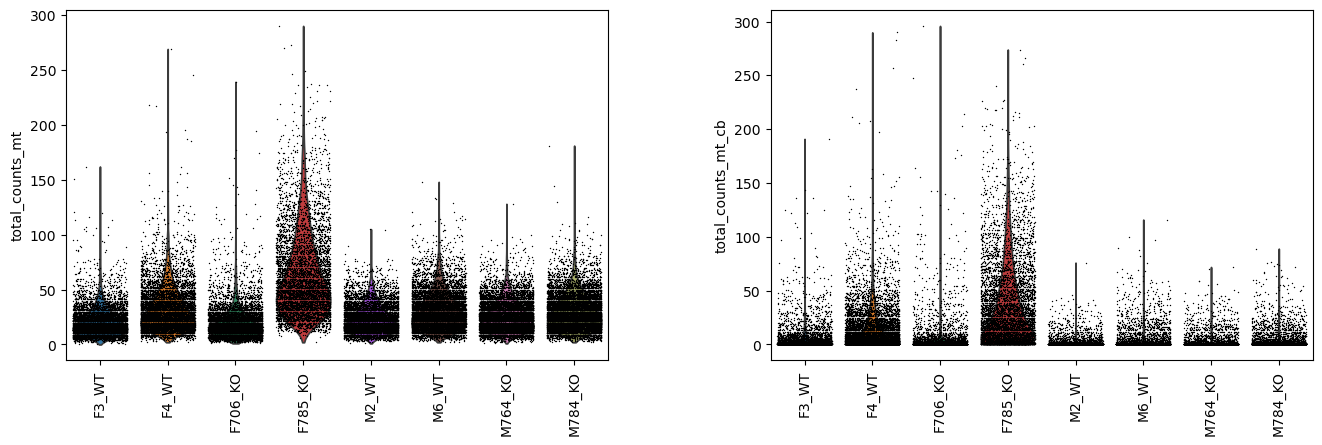

In [27]:
sc.pl.violin(
    adata_combined,
    ["total_counts_mt", "total_counts_mt_cb"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)